In [1]:
import nltk
from nltk.corpus import brown, gutenberg, shakespeare, wordnet, reuters
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
wordnet_lemmatizer = WordNetLemmatizer()
from xml.etree import ElementTree

# Import lexicon
from nltk.corpus import words
lex = words.words('en')

import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline
import numpy as np

/Users/Raquel/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
# Prefixes of interest
prefixes_pattern = "un|non|dis|in"
prefixes = ["un", "non", "dis", "in"]

# Function to replace treebank tag with a wordnet tag to use with the Lemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # Unfortunately, wordnet only supports adjective, verb, noun and adverb parts of speech
        # So, any word whose POS is not covered by wordnet will default to NOUN
        return wordnet.NOUN

def process_shakespeare(shakespeare):
    plays = shakespeare.fileids() # doctest: +ELLIPSIS
    shk_words = []
    for play in plays:
        lines = [str(line.text) for line in shakespeare.xml(play).findall('ACT/SCENE/SPEECH/LINE')]
        for l in lines:
            shk_words += word_tokenize(l)
    return shk_words

In [3]:
def tuplize(matched_word):  
    word = matched_word[0]
    tag = matched_word[1]
    # Separate prefix from stem
    prefix = re.match(prefixes_pattern, word).group(0)
    stem = re.sub(prefix, '', word, count=1)
    lem_stem = wordnet_lemmatizer.lemmatize(stem, pos=(get_wordnet_pos(tag)))
    return (word, tag, prefix, stem, lem_stem)

def find_affixes(corpus_words):
    # Get all tokens that have prefixes of interest
    pattern = r'\bun\w+|\bnon\w+|\bdis\w+|\bin\w+'
    prefixed_words = list(set([w for w in corpus_words if re.match(pattern, w) and len(w) > 3]))
    
    # Tag words
    # Words_tagged is a list of tuples containing (word, tag)
    words_tagged = nltk.pos_tag(prefixed_words)
    
    # (word, pos_tag, prefix, stem, lemmatized_stem)
    # e.g. (disproportionate, JJ, dis, proportionate, )
    words_of_interest = [tuplize(w) for w in words_tagged]

    # Get rid of erroneous words of interest
    # Check if stem is in the lexicon
    # If so, the prefix is negating and keep the word
    # If not, discard the word
    filtered = [w for w in words_of_interest if len(w[4]) > 1 and w[4] in lex]
    
    return filtered

In [4]:
def get_filtered_words(filtered):
    return [f[0] for f in filtered]

In [5]:
# Token frequency: Number of actual words formed according to a certain pattern over the corpus
def token_frequency(words, corpus_words):
    token_freqs = dict(zip(prefixes, ([0]*len(prefixes))))
    for c in corpus_words:
        if c in words:
            # Compute frequencies
            prefix = re.match(prefixes_pattern, c).group(0)
            token_freqs[prefix] += 1
    return token_freqs
            
def type_frequency(filtered):
    type_freqs = dict(zip(prefixes, ([0]*len(prefixes))))
    for f in filtered:
        # Compute frequencies
        prefix = re.match(prefixes_pattern, f).group(0)
        type_freqs[prefix] += 1
    return type_freqs

def pie_chart(freqs):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = [pf.capitalize() + "-" for pf in freqs]
    sizes = [freqs[pf] for pf in freqs]
    explode = (0, 0, 0, 0)

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    
def analyze(corpus_words, filtered_words):
    corpus_size = len(corpus_words)
    filtered_size = len(filtered_words)
    prefix_tk_freqs = token_frequency(filtered_words, corpus_words)
    prefix_ty_freqs = type_frequency(filtered_words)

    for pf in prefixes:
        prefix_tk_freqs[pf] /= corpus_size

    for pf in prefixes:
        prefix_ty_freqs[pf] /= filtered_size

    for pf in prefixes:
        print("Token frequency of {} = {}".format(pf, prefix_tk_freqs[pf]*100))
    print()    
    for pf in prefixes:
        print("Type frequency of {} = {}".format(pf, prefix_ty_freqs[pf]*100))

    pie_chart(prefix_ty_freqs)

Token frequency of un = 0.19815844408159888
Token frequency of non = 0.009042432259264618
Token frequency of dis = 0.12047964505439238
Token frequency of in = 0.47003424067682176

Type frequency of un = 41.427399507793275
Type frequency of non = 4.1837571780147655
Type frequency of dis = 20.91878589007383
Type frequency of in = 33.470057424118124


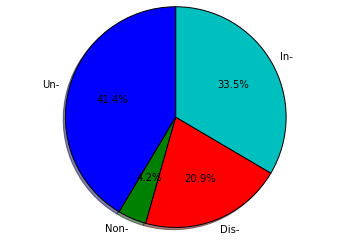

Token frequency of un = 0.486265516687627
Token frequency of non = 0.0024793895971678506
Token frequency of dis = 0.07091054247900053
Token frequency of in = 0.34154545312370665

Type frequency of un = 51.90938511326861
Type frequency of non = 0.3236245954692557
Type frequency of dis = 18.18770226537217
Type frequency of in = 29.579288025889966


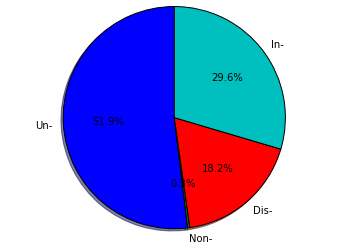

Token frequency of un = 0.16345301418439717
Token frequency of non = 0.00046173167848699765
Token frequency of dis = 0.10943040780141844
Token frequency of in = 0.18746306146572106

Type frequency of un = 48.704663212435236
Type frequency of non = 0.2590673575129534
Type frequency of dis = 23.316062176165804
Type frequency of in = 27.72020725388601


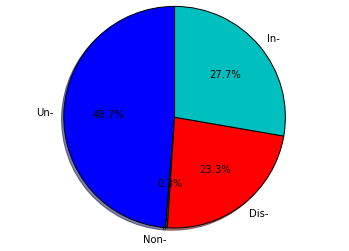

Token frequency of un = 0.175663794721486
Token frequency of non = 0.0030797820444058085
Token frequency of dis = 0.09861113451616335
Token frequency of in = 0.37259551827792536

Type frequency of un = 35.37906137184115
Type frequency of non = 5.595667870036101
Type frequency of dis = 25.27075812274368
Type frequency of in = 33.754512635379065


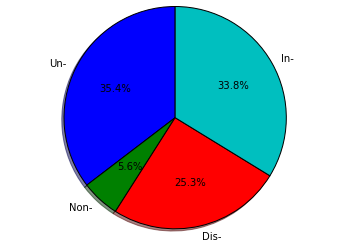

In [6]:
# Step 4: Analysis
corpora_words = [brown.words(), gutenberg.words(), process_shakespeare(shakespeare), reuters.words()]

for cw in corpora_words:
    words_filtered = get_filtered_words(find_affixes(cw))
    analyze(cw, words_filtered)

In [7]:
def stacked_bar_graph(cats, freqs):
    # Create the general blog and the "subplots" i.e. the bars
    f, ax1 = plt.subplots(1, figsize=(20,15))

    # Set the bar width
    bar_width = 0.75

    # positions of the left bar-boundaries
    bar_l = [i+1 for i in range(len(cats))]

    # positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i+(bar_width/2) for i in bar_l]
    
    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            # using frequency
            [freqs[cat]['in'] for cat in cats],
            # set the width
            width=bar_width,
            # with the label pre score
            label='in',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='b')
    
    ax1.bar(bar_l,
            # using frequency
            [freqs[cat]['dis'] for cat in cats],
            # set the width
            width=bar_width,
            bottom=[freqs[cat]['in'] for cat in cats],
            # with the label pre score
            label='dis',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='g')
    
    ax1.bar(bar_l,
            # using frequency
            [freqs[cat]['non'] for cat in cats],
            # set the width
            width=bar_width,
            # with the label pre score
            bottom=[i+j for i,j in zip([freqs[cat]['in'] for cat in cats],[freqs[cat]['dis'] for cat in cats])],
            label='non',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='y')
    
    ax1.bar(bar_l,
            # using frequency
            [freqs[cat]['un'] for cat in cats],
            # set the width
            width=bar_width,
            bottom=[i+j+k for i,j,k in zip([freqs[cat]['in'] for cat in cats],[freqs[cat]['dis'] for cat in cats],
                                        [freqs[cat]['non'] for cat in cats])],
            # with the label pre score
            label='un',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='r')

    # set the x ticks with names
    plt.xticks(tick_pos, cats)

    # Set the label and legends
    ax1.set_ylabel("Type frequency")
    ax1.set_xlabel("Categories")
    plt.legend(loc='upper left')

    # Set a buffer around the edge
    plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

In [10]:
def gutenberg_cats(cat):
    if cat == 'religion':
        return ["bible-kjv.txt"]
    elif cat == 'poem':
        return ["blake-poems.txt", "milton-paradise.txt", "whitman-leaves.txt"]
    elif cat == 'play':
        return ['shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt']
    else:
        return ['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bryant-stories.txt', 
         'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 
         'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt']

def words_by_cat(corpus, cat):
    if corpus == gutenberg:
        gt_words = []
        for f in gutenberg_cats(cat):
            gt_words += word_tokenize(gutenberg.raw(f))
        return gt_words
    elif corpus == brown:
        return brown.words(categories=cat)

In [11]:
all_categories = brown.categories() + ['play', 'poem']
pf_freqs = dict(zip(prefixes, [0]*len(prefixes)))
ty_freqs = dict(zip(all_categories, [pf_freqs]*len(all_categories)))
    
brown_ty_fqs = dict(zip(brown.categories(), [pf_freqs]*len(brown.categories())))
for cat in brown.categories():
    ty_freqs[cat] = type_frequency(get_filtered_words(find_affixes(words_by_cat(brown, cat))))
        
gut_cats = ['fiction', 'religion', 'poem', 'play']
gtbg_ty_freqs = dict(zip(gut_cats, [pf_freqs]*len(gut_cats)))
for cat in gut_cats:
    gtbg_ty_freqs[cat] = type_frequency(get_filtered_words(find_affixes(words_by_cat(gutenberg, cat))))
    for pf in gtbg_ty_freqs[cat]:
        ty_freqs[cat][pf] += gtbg_ty_freqs[cat][pf]

ty_freqs['play'] = type_frequency(get_filtered_words(find_affixes(process_shakespeare(shakespeare))))
                         
ty_freqs['news'] = type_frequency(get_filtered_words(find_affixes(reuters.words())))

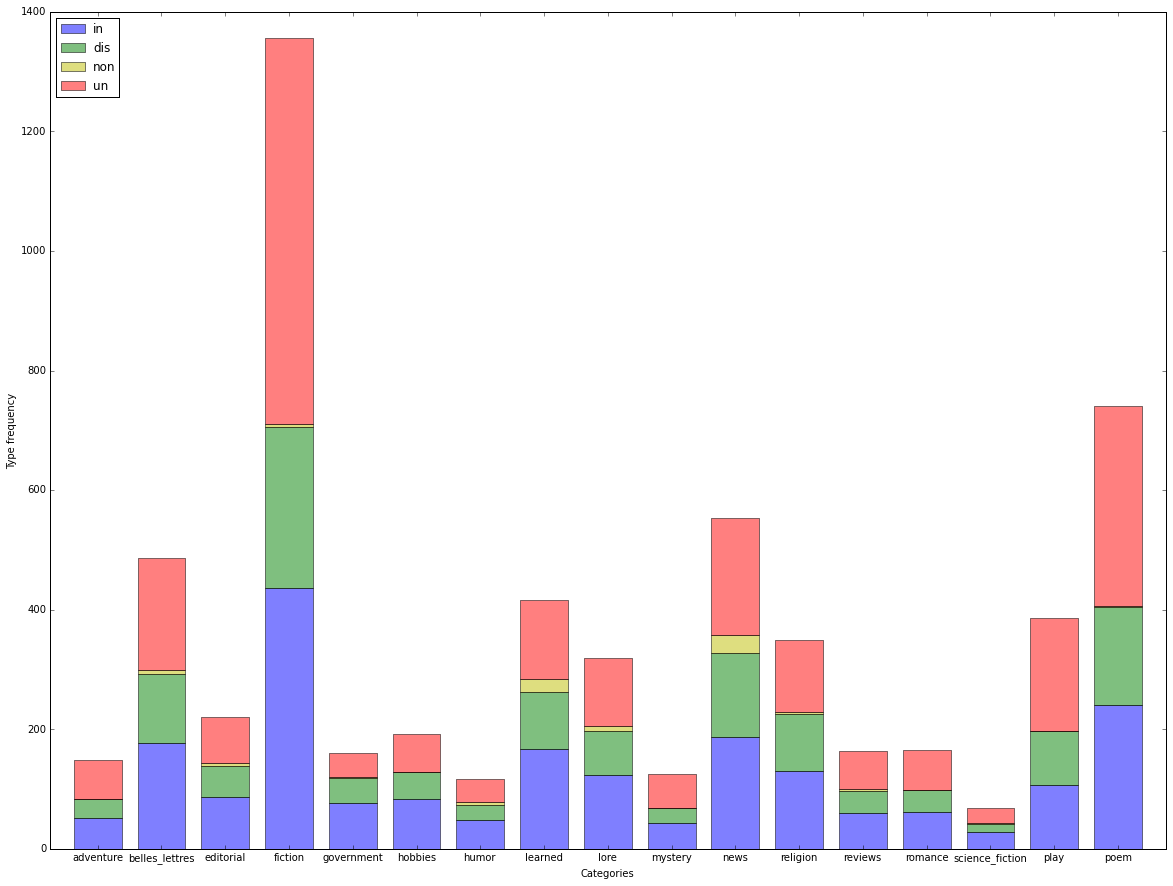

In [12]:
stacked_bar_graph(all_categories, ty_freqs)

Token frequency of un = 0.32507138634074334
Token frequency of non = 0.003915890859926136
Token frequency of dis = 0.09821194129939748
Token frequency of in = 0.3723592648054764

Type frequency of un = 45.65334773218142
Type frequency of non = 2.375809935205184
Type frequency of dis = 20.680345572354213
Type frequency of in = 31.290496760259177


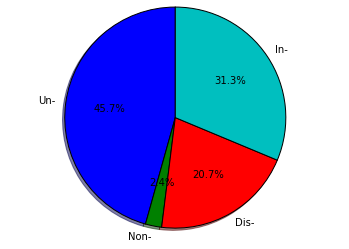

In [15]:
corpora_words = [brown.words(), gutenberg.words(), process_shakespeare(shakespeare), reuters.words()]

all_words = []
all_filtered_words = []
for cw in corpora_words:
    all_words += cw
    all_filtered_words += get_filtered_words(find_affixes(cw))

analyze(all_words, all_filtered_words)

In [13]:
filtered_words = []
for cw in corpora_words:
    filtered_words += get_filtered_words(find_affixes(cw))
    
for f in filtered_words:
    print(f)

unqualified
uncertainly
discontented
inlaid
undoing
incompetent
inconvenient
insets
innovate
inappropriate
uncircumcision
unreason
incorporation
insights
unabashed
inmate
intrusion
untouched
unenthusiastic
unrestrictedly
unsaturated
unsupportable
disgraceful
unlamented
disengagement
incite
uninjectable
unfounded
innocent
disrepute
unwarrantable
unreleased
indecent
unassisted
dishonest
incompatibility
unprovocative
unpleasant
unrealistically
unstrung
uncover
unconditionally
dissolve
dismiss
unbounded
incorrigible
intern
disallowed
displace
inaccuracies
unattended
uncolored
insect
dissent
unselfishly
unbound
nonagricultural
disrespect
distrust
unlock
inside
unease
undreamt
undressed
dissatisfaction
unconcern
insubordination
unprepared
uninterruptedly
nonequivalence
disclose
unfit
inadequacies
unfunny
inhumane
unblushing
unenvied
discovers
inaction
unreality
inaudible
insight
inapt
discussed
unaggressive
disproving
disorganized
infinite
nondrying
dissociation
disagrees
disagreed
inordinat

In [19]:
from collections import defaultdict
lemma = defaultdict(set)
for t in find_affixes(gutenberg.words()):
    word = t[0]
    tag = t[1]
    prefix = t[2]
    stem = t[3]
    lem_stem = t[4]
    lemma[lem_stem].add(t)

for l in lemma:
    if len(lemma[l]) > 1:
        prefixes = [t[2] for t in lemma[l]]
        words = [t[0] for t in lemma[l]]
        if len(set(prefixes)) > 1:
            print('{} = {}'.format(l, words))

rolled = ['inrolled', 'unrolled']
ion = ['inions', 'union']
decipherable = ['undecipherable', 'indecipherable']
belief = ['unbelief', 'disbelief']
grateful = ['ungrateful', 'ingrateful']
to = ['unto', 'into']
claim = ['disclaims', 'disclaiming', 'disclaimed', 'unclaim']
armed = ['disarmed', 'unarmed']
satiable = ['insatiable', 'unsatiable']
utterable = ['inutterable', 'unutterable']
quietude = ['inquietudes', 'disquietude', 'inquietude']
quiet = ['disquiet', 'unquiet', 'disquieted']
believe = ['disbelieve', 'unbelieving', 'disbelieving']
corrupt = ['discorrupt', 'incorrupt']
possess = ['dispossessed', 'unpossessed']
form = ['inform', 'informs', 'unformed', 'informed', 'informes', 'informing', 'unform']
satisfied = ['dissatisfied', 'unsatisfied']
please = ['displeased', 'unpleasing', 'displease']
like = ['disliked', 'unlike', 'dislikes', 'dislike', 'disliking']
trust = ['intrust', 'intrusted', 'distrusted', 'distrusting', 'distrusts', 'distrust']
fixed = ['unfixed', 'infixed']
arm = ['i